# COGS 108 - EDA Checkpoint

# Names

- Scott Yang
- Beibei Du
- Lulu Tong
- Jinghan Cao

<a id='research_question'></a>
# Research Question

*How does remote learning at UCSD during COVID-19 pandemic affect undergraduate students' academic performance and expectation?*

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format ='retina'

In [2]:
cape = pd.read_csv("CAPE_all.csv")

In [3]:
survey = pd.read_csv("COGS 108 UCSD e-learning survey 02-23.csv")

# Data Cleaning

## CAPE Data Cleaning

Parse out course code and course description and extract useful data information from the dataset. We make the study hours to numeric values.

In [56]:
cape = cape.assign(course_code = cape['Course'].apply(lambda course: str(course).split('-')[0][:-1]))
cape = cape.assign(department = cape["course_code"].apply(lambda code: str(code).split()[0]))
cape = cape.assign(course_num = cape["course_code"].apply(
    lambda code: str(code).split()[1] 
    if len(str(code).split()) == 2 else code))
cape = cape.assign(course_description = cape['Course'].apply(
    lambda course: str(course).split('-')[1] if len(str(course).split('-')) == 2 else course))
cape.head()

,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,course_code,department,course_num,course_description,eval_percent
0,"Jones, Ian William Nasser",ANAR 120 - Documenting Climate Change (A),FA20,15.0,4.0,100.00%,100.00%,2.50,B+ (3.50),NaN,ANAR 120,ANAR,120,Documenting Climate Change (A),0.266667
1,"Smith, Neil Gordon",ANAR 121 - Cyber-Archaeology (A),FA20,17.0,6.0,100.00%,100.00%,6.50,A (4.00),NaN,ANAR 121,ANAR,121,ANAR 121 - Cyber-Archaeology (A),0.352941
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,41.0,16.0,100.00%,100.00%,4.00,A- (3.81),A- (3.79),ANAR 146,ANAR,146,Feeding the World (A),0.390244
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,20.0,15.0,93.30%,100.00%,2.77,B+ (3.67),A- (3.77),ANBI 118,ANBI,118,Technology on the Go (A),0.750000
4,"Fox, Patrick Keolu Ozer",ANBI 121 - Polynesian Navigation (A),FA20,14.0,10.0,100.00%,100.00%,2.72,B+ (3.67),NaN,ANBI 121,ANBI,121,Polynesian Navigation (A),0.714286


Clean out the Avg Grade Expected and Avg Grade Received into numeric values. 
First, Create a new dataFrame for this analysis called grade

We willclean out the unrelated factor and drop the coloumn of grades where have NaN value.

In [5]:
cape.isnull().sum()

Instructor               69
Course                   60
Term                     60
Enroll                   60
Evals Made               60
Rcmnd Class              60
Rcmnd Instr              60
Study Hrs/wk             61
Avg Grade Expected     1425
Avg Grade Received    14536
course_code               0
department                0
course_num                0
course_description       60
dtype: int64

The column "Avg Grade Expected" and "Avg Grade Received" have the most null values. We are removing these data because in order to measure the performance, we would need the both the expected grade and received grade. Therefore, we are removing these null values.

In [6]:
grade = cape[['Instructor', 'Course', 'Term', 'Study Hrs/wk', 'Avg Grade Expected', 'Avg Grade Received']][
    (cape["Avg Grade Expected"].notna()) & (cape["Avg Grade Received"].notna())
]
grade.head()

,Instructor,Course,Term,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,4.00,A- (3.81),A- (3.79)
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,2.77,B+ (3.67),A- (3.77)
5,"Semendeferi, Ekaterini",ANBI 136 - Human Comparative Neuroanatomy (A),FA20,5.17,B (3.27),B- (2.99)
6,"Gagneux, Pascal",ANBI 141 - The Evolution of Human Diet (A),FA20,3.75,B+ (3.70),A- (3.87)
9,"Olivas Hernandez, Olga Lid",ANSC 121 - Psychological Anthropology (A),FA20,3.83,A- (3.77),A- (3.91)


Parse out the Numeric GPA and the letter grade.

In [7]:
GPA_Expected = grade['Avg Grade Expected'].apply(lambda grade: float(grade.split()[1][1:-1]))
GPA_Received = grade['Avg Grade Received'].apply(lambda grade: float(grade.split()[1][1:-1]))
letter_Recieved = grade['Avg Grade Received'].apply(lambda grade: grade.split()[0])

grade.head()

,Instructor,Course,Term,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,4.00,A- (3.81),A- (3.79)
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,2.77,B+ (3.67),A- (3.77)
5,"Semendeferi, Ekaterini",ANBI 136 - Human Comparative Neuroanatomy (A),FA20,5.17,B (3.27),B- (2.99)
6,"Gagneux, Pascal",ANBI 141 - The Evolution of Human Diet (A),FA20,3.75,B+ (3.70),A- (3.87)
9,"Olivas Hernandez, Olga Lid",ANSC 121 - Psychological Anthropology (A),FA20,3.83,A- (3.77),A- (3.91)


Some courses' evaluation are based on a small sample size, that might made the evaluation biased. We need a metric of the percentage of evaluation made.

We could calculate the percentage of response of each class of student. That is calculated by dividing the Enroll by the `Evals Mades`columns

We want to make sure the analysis that we have conduct is valid and convincing

In [8]:
cape = cape.assign(eval_percent = cape['Evals Made'] / cape['Enroll'])
cape.head()

,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,course_code,department,course_num,course_description,eval_percent
0,"Jones, Ian William Nasser",ANAR 120 - Documenting Climate Change (A),FA20,15.0,4.0,100.00%,100.00%,2.50,B+ (3.50),NaN,ANAR 120,ANAR,120,Documenting Climate Change (A),0.266667
1,"Smith, Neil Gordon",ANAR 121 - Cyber-Archaeology (A),FA20,17.0,6.0,100.00%,100.00%,6.50,A (4.00),NaN,ANAR 121,ANAR,121,ANAR 121 - Cyber-Archaeology (A),0.352941
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,41.0,16.0,100.00%,100.00%,4.00,A- (3.81),A- (3.79),ANAR 146,ANAR,146,Feeding the World (A),0.390244
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,20.0,15.0,93.30%,100.00%,2.77,B+ (3.67),A- (3.77),ANBI 118,ANBI,118,Technology on the Go (A),0.750000
4,"Fox, Patrick Keolu Ozer",ANBI 121 - Polynesian Navigation (A),FA20,14.0,10.0,100.00%,100.00%,2.72,B+ (3.67),NaN,ANBI 121,ANBI,121,Polynesian Navigation (A),0.714286


# --------------- ---------------  Combine the above code ------------  --------------- 

We are not dropping the `NaN` value in our global `cape` dataset because only a small portion of the data has the complete entries. This is most likely due to the span of our dataset. In detail, some data might not available before the year 2010. 

We will drop the `NaN` value later on when we are interested in specific features such as `grade` and `gpa`.

In [9]:
## YOUR CODE HERE
cape = pd.read_csv("CAPE_all.csv")
cape = cape.assign(course_code = cape['Course'].apply(lambda course: str(course).split('-')[0][:-1]))
cape = cape.assign(department = cape["course_code"].apply(lambda code: str(code).split()[0]))
cape = cape.assign(course_num = cape["course_code"].apply(
    lambda code: str(code).split()[1] 
    if len(str(code).split()) == 2 else code))
cape = cape.assign(course_description = cape['Course'].apply(
    lambda course: str(course).split('-')[1] if len(str(course).split('-')) == 2 else course))
cape.head()
grade = cape[['Instructor', 'Course', 'Term', 'Study Hrs/wk', 'Avg Grade Expected', 'Avg Grade Received']][
    (cape["Avg Grade Expected"].notna()) & (cape["Avg Grade Received"].notna())
]
grade = grade.assign(
    GPA_Expected = grade['Avg Grade Expected'].apply(lambda grade: float(grade.split()[1][1:-1])),
    GPA_Received = grade['Avg Grade Received'].apply(lambda grade: float(grade.split()[1][1:-1])),
    letter_Recieved = grade['Avg Grade Received'].apply(lambda grade: grade.split()[0])
)
cape = cape.assign(eval_percent = cape['Evals Made'] / cape['Enroll'])

In [53]:
cape.head(2)

,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,course_code,department,course_num,course_description,eval_percent
0,"Jones, Ian William Nasser",ANAR 120 - Documenting Climate Change (A),FA20,15.0,4.0,100.00%,100.00%,2.5,B+ (3.50),NaN,ANAR 120,ANAR,120,Documenting Climate Change (A),0.266667
1,"Smith, Neil Gordon",ANAR 121 - Cyber-Archaeology (A),FA20,17.0,6.0,100.00%,100.00%,6.5,A (4.00),NaN,ANAR 121,ANAR,121,ANAR 121 - Cyber-Archaeology (A),0.352941


In [54]:
grade.head(2)

,Instructor,Course,Term,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,GPA_Expected,GPA_Received,letter_Recieved
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,4.00,A- (3.81),A- (3.79),3.81,3.79,A-
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,2.77,B+ (3.67),A- (3.77),3.67,3.77,A-


# ------------------------------------------------------------------------------------------------------------

## Survey Data Cleaning

First, we will clean the dataset by changing the columns names and remove the timestamp column

In [15]:
survey = survey.drop(survey.columns[0], axis = 1)

We rename the columns by replacing all the questions that we have asked in the Google survey

In [16]:
survey.columns = ['agreement','undergrad','quarters',
    'studytime_during','studytime_before', 'studytime_rating',
    'experience_rating', 'performance_rating','gpa_before',
    'gpa_during', 'expected_gpa']

Then we will have to remove any observations that answered `NO` to the agreement and who are not an undergraduate UCSD students because it is out of the scope of our research.

In [17]:
survey = survey[(survey['agreement'] == 'Yes')&(survey['undergrad'] == 'YES')].reset_index()

Check if all observations answered `no/No/NO` to first two questions are removed. We will only use the data from those who are UCSD undergrad and agree to use the data for analysis.

In [18]:
print(survey['agreement'].unique())
print(survey['undergrad'].unique())

['Yes']
['YES']


### Sub datasets for ratings, study time and gpa

There are three questions asking about students rating on remote leanring, all three are answered in a scale from 1 to 5. We will have a separate dataset for these three questions. Also, in the survey, we asked questions on both study time and students' gpa. To avoid confusion and for better analyzing the data, we will separate these into two data sets. By previewing the datasets, we found there were students who did not provide answers to certain questions, but other questions were answered. We are separating the datasets so that when we are removing null values, we are keep the answers to other questions provided by the student.

Dataset for students' ratings on remote learning

In [19]:
rating_df = survey[['studytime_rating', 'performance_rating', 'experience_rating']]

In [20]:
rating_df = rating_df.apply(pd.to_numeric)
rating_df.head()

,studytime_rating,performance_rating,experience_rating
0,4,4,3
1,3,4,4
2,1,2,3
3,2,4,4
4,4,2,2


Dataset for students' study hours before and during remote learning

In [21]:
studytime_df = survey[['studytime_before' ,'studytime_during']]
studytime_df.head()

,studytime_before,studytime_during
0,4,7
1,NaN,7
2,8,6
3,NaN,18
4,NaN,8


In order to measure the difference of study hours before and during the pandemic, we need data on both studytime_before and studytime_during. Null values are make it difficult to compare the differences and we will remove the null values.

In [22]:
studytime_df = studytime_df.dropna()
print(studytime_df['studytime_during'].unique())
print(studytime_df['studytime_before'].unique())

['7' '6' '1' '4' '8' '2.5' '10' '40' '3-5' '2' '20' '6.5' '6-8' '30'
 '20 hours' '35' '3' '80']
['4' '8' '1' '3' '6' '30' '4-6' '20' '7' '10-12' '12' '35' '10' '60' '2']


When previewing the data, we found that some data contains units such as \"hours, hour\", we need to git rid of the units and compare only the numeric values.We write out a function to get rid of the units to standardize the study time hours before and during the pandemic.

In [23]:
def removeunit(string):
    string = string.lower()
    string = string.strip()
    
    string = string.replace('hours', '') 
    string = string.replace('hour', '')
    string = string.replace('hrs', '')
        
    string = string.strip()
    return string

studytime_df['studytime_during'] = studytime_df['studytime_during'].apply(removeunit)
studytime_df['studytime_before'] = studytime_df['studytime_before'].apply(removeunit)
studytime_df
studyhour_before = studytime_df['studytime_during']
studytime_df['studytime_during'] = studyhour_before.str.rstrip(' hours hour')
studytime_df.head()


,studytime_before,studytime_during
0,4,7
2,8,6
5,1,1
9,8,7
10,3,4


Also, we've noticed that some students provided a range of hours instead of a number. For the purpose of analyzing, we will take the average values and use these instead.We transform the datatype into float, and then take the average study hours.

In [57]:
time1 = studytime_df['studytime_during'].apply(lambda studytime_during: str(studytime_during).split('-')[0])
time2 = studytime_df['studytime_during'].apply(lambda studytime_during: str(studytime_during).split('-')[-1])
new_time_during = (time1.astype(float) + time2.astype(float))/ 2

new_time_during
studytime_df['studytime_during'] = new_time_during

In [58]:
time1 = studytime_df['studytime_before'].apply(lambda studytime_before: str(studytime_before).split('-')[0])
time2 = studytime_df['studytime_before'].apply(lambda studytime_before: str(studytime_before).split('-')[-1])
new_time_before = (time1.astype(float) + time2.astype(float))/ 2
new_time_before

studytime_df['studytime_before'] = new_time_before
studytime_df.head()


,studytime_before,studytime_during,diff
0,4.0,7.0,3.0
2,8.0,6.0,-2.0
5,1.0,1.0,0.0
9,8.0,7.0,-1.0
10,3.0,4.0,1.0


In [26]:
studytime_df.reset_index()
studytime_df.dtypes

studytime_before    float64
studytime_during    float64
dtype: object

Dataset for students' GPA before and during remote learning


In [27]:
GPA_df = survey[['gpa_before','gpa_during']]

To compare, we will need to have data of GPA both before and during the pandemic, to do so, we will remove all the null values as they do not contribute to our questions here.

In [28]:
GPA_df = GPA_df.dropna()
GPA_df.head()

,gpa_before,gpa_during
0,4,3.9
2,3.8,3.9
5,3.785,4.0
7,NA,3.2
9,3.6,3.7


While viewing only the top several observations, we found that there are other null values that haven't been removed. We will remove these as well.We will remove the `NA` values from our dataset.

In [29]:
GPA_df = GPA_df[GPA_df['gpa_before'].apply(lambda gpa: gpa != " NA")]

Now we have all the values, we will convert the datatype to numerics.

In [30]:
GPA_df['gpa_before'] = GPA_df['gpa_before'].astype(float)
GPA_df['gpa_during'] = GPA_df['gpa_during'].astype(float)

In [31]:
GPA_df.reset_index()
GPA_df.dtypes

gpa_before    float64
gpa_during    float64
dtype: object

# Data Analysis & Results (EDA)

### EDA for CAPE dataset

## Is the `GPA_predicted` a good predictor for `GPA_recieved`?

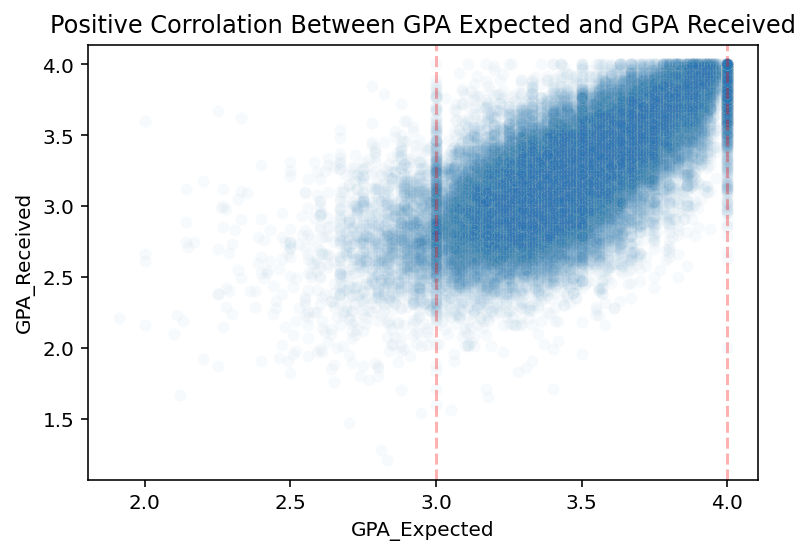

In [32]:
gpa_sub = grade[['GPA_Expected', 'GPA_Received']].reset_index()
ax = sns.scatterplot(x='GPA_Expected', y='GPA_Received', data=gpa_sub, alpha=0.03)
ax.set_title("Positive Corrolation Between GPA Expected and GPA Received")
ax.axvline(3.0, ls='--', color='r', alpha=0.3)
ax.axvline(4.0, ls='--', color='r', alpha=0.3)

Notice that there are great concentration of data point on the 3.0 and 4.0 GPAs expected. Nevertheless, the GPAs received does not have great clusteres. The reason why there are cluster on the 3.0, 4.0 GPAs expected is because of the evaluation are usually directly makes out from the whole number.

There might be too much data point for our analysis. For our research question, we can focus on the `FA20` and `FA19` terms, which corresponding to the **Post Covid** and **Pre Covid** respectively.

The reason we chose the `FA19` and `FA20` terms to compare is under the rational that the courses offered in Fall Quarter should be comparable in terms of the course offerings, professor who teach the corresponding course, and the similar difficulties of each courses.

Text(0.5, 1.0, 'Overall Trend Alikes between FA20 and FA19')

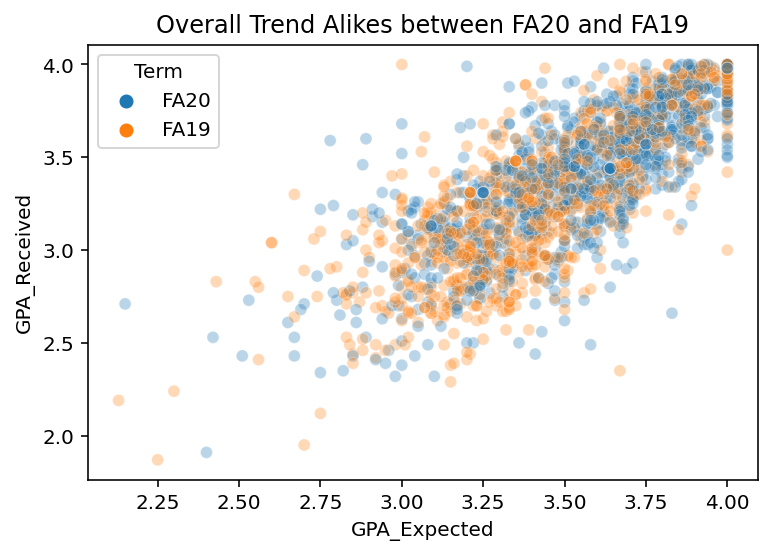

In [33]:
grade_FA = grade[grade['Term'].apply(lambda term: term in ["FA20", "FA19"])]
ax = sns.scatterplot(x='GPA_Expected', y='GPA_Received', hue="Term", data=grade_FA, alpha=0.3)
ax.set_title("Overall Trend Alikes between FA20 and FA19")

In [59]:
grade.head(3)

,Instructor,Course,Term,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,GPA_Expected,GPA_Received,letter_Recieved
2,"D'Alpoim Guedes, Jade A",ANAR 146 - Feeding the World (A),FA20,4.00,A- (3.81),A- (3.79),3.81,3.79,A-
3,"Fox, Patrick Keolu Ozer",ANBI 118 - Technology on the Go (A),FA20,2.77,B+ (3.67),A- (3.77),3.67,3.77,A-
5,"Semendeferi, Ekaterini",ANBI 136 - Human Comparative Neuroanatomy (A),FA20,5.17,B (3.27),B- (2.99),3.27,2.99,B-


### Is the distribution of difference between the expected value and Received Value from `FA19` and `FA20` different?


Text(0.5, 1.0, 'FA20 Student predict their grade more accurate than FA19')

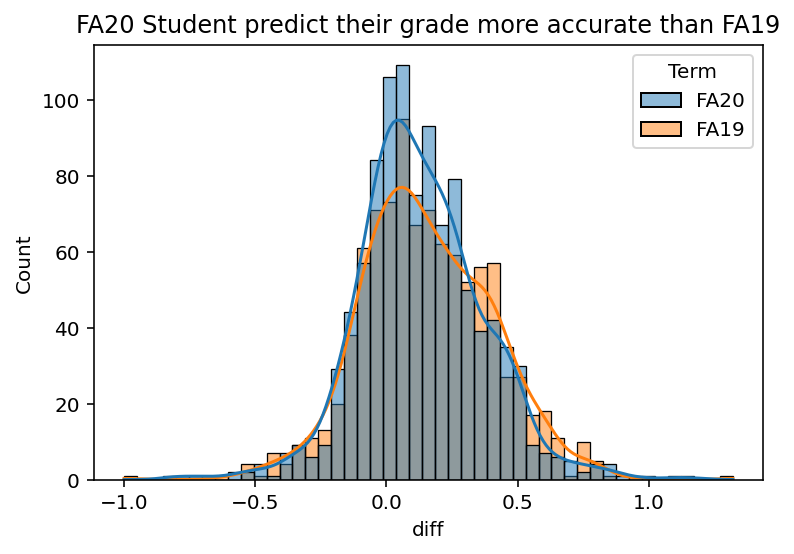

In [35]:
grade_FA_diff = grade_FA.assign(diff = grade_FA['GPA_Expected'] - grade_FA['GPA_Received'])
ax = sns.histplot(x='diff', hue='Term', data=grade_FA_diff, kde=True)
ax.set_title("FA20 Student predict their grade more accurate than FA19")

In [91]:
cape.head(2)

,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received,course_code,department,course_num,course_description,eval_percent
0,"Jones, Ian William Nasser",ANAR 120 - Documenting Climate Change (A),FA20,15.0,4.0,100.00%,100.00%,2.5,B+ (3.50),NaN,ANAR 120,ANAR,120,Documenting Climate Change (A),0.266667
1,"Smith, Neil Gordon",ANAR 121 - Cyber-Archaeology (A),FA20,17.0,6.0,100.00%,100.00%,6.5,A (4.00),NaN,ANAR 121,ANAR,121,ANAR 121 - Cyber-Archaeology (A),0.352941


In [99]:
cape['Term'].unique()

array(['FA20', 'S220', 'S120', 'SP20', 'WI20', 'FA19', 'S319', 'S219',
       'S119', 'SP19', 'WI19', 'FA18', 'S218', 'S118', 'SP18', 'WI18',
       'FA17', 'S217', 'S117', 'SP17', 'WI17', 'FA16', 'S216', 'S116',
       'SP16', 'WI16', 'FA15', 'S215', 'S115', 'SP15', 'WI15', 'FA14',
       'S214', 'S114', 'SP14', 'WI14', 'FA13', 'S213', 'S113', 'SP13',
       'WI13', 'FA12', 'S212', 'S112', 'SP12', 'WI12', 'FA11', 'S311',
       'S211', 'S111', 'SP11', 'WI11', 'FA10', 'SU10', 'SP10', 'WI10',
       'FA09', 'SU09', 'SP09', 'WI09', 'FA08', 'SU08', 'SP08', 'WI08',
       'FA07', 'SU07', nan, 'S313', 'S320', 'S317', 'S316', 'S318',
       'S315', 'S314', 'S312'], dtype=object)

In [104]:
cape[cape['Term'] == 'FA20']['Study Hrs/wk'].median()

5.5

In [105]:
cape[cape['Term'] == 'FA19']['Study Hrs/wk'].median()

5.15

In [118]:
cape[cape['Term'] == 'SP20']['Study Hrs/wk'].median()

5.4350000000000005

In [112]:
cape[cape['Term'] == 'FA18']['Study Hrs/wk'].median()

5.13

In [132]:
fall_contrast = pd.DataFrame().assign(
    semester = ['FA18','FA19', 'SP20','FA20'],
    median = [5.13,5.15,5.435, 5.5]
)
fall_contrast

,semester,median
0,FA18,5.130
1,FA19,5.150
2,SP20,5.435
3,FA20,5.500


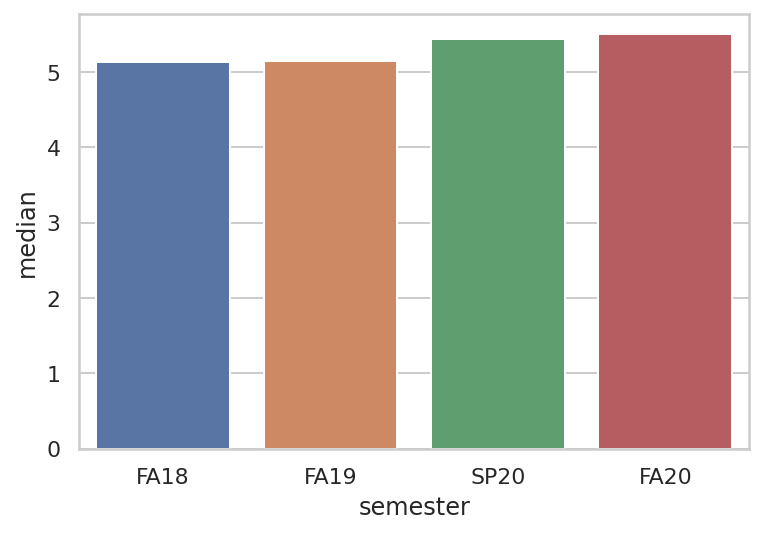

In [133]:
sns.set_theme(style="whitegrid")
sns.barplot(x = 'semester', y = 'median', data = fall_contrast)

### EDA for Survey dataset

In the survey, we have three questions that directly asked students about how they feel about the online learning experiences, including effects on study hours, academic performance and overall experiences. We asked students to answer in a scale from 1 to 5.

In the question **Do you think remote learning makes you spend more time on studying?** 1 means spend less time and 5 means spend more time.

In the question **How do you think the online learning affect your academic performance?** 1 means negatively affected and 5 means positively affected

In the question **How do you rank your overall remote learning experience after pandemic (since SP20)?** 1 means least satisfied and 5 means most satisfied

#### Plots on self-reported ratings of remote learning

Text(0.5, 1.0, "Students' rating on study time before and during remote learning")

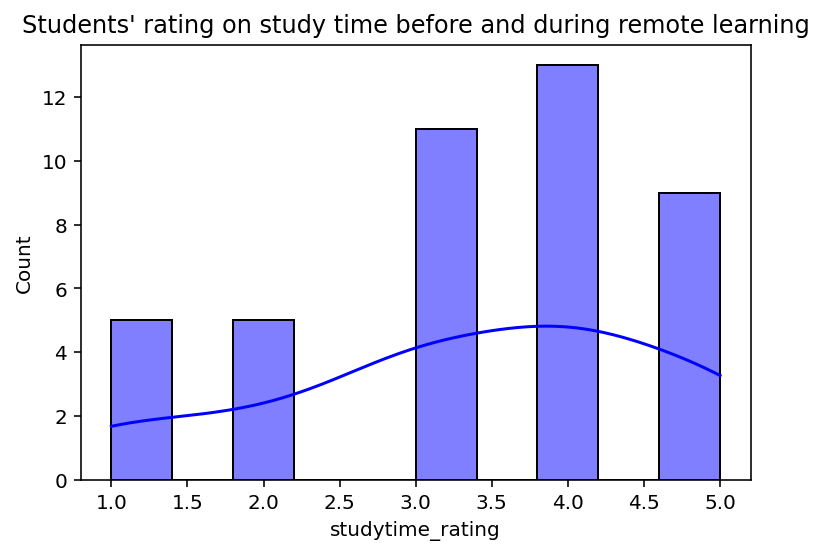

In [36]:
studyhour_plot = sns.histplot(x='studytime_rating', data = rating_df, kde = True, bins = 10, color = 'blue')
studyhour_plot.set_title("Students' rating on study time before and during remote learning")

From the self-reported rating on study time before and during remote learning, the plot shows that more students answered 3/4/5, which means they are spending more time studying during the pandemic than before.

Text(0.5, 1.0, "Students' rating on academic performance before and during remote learning")

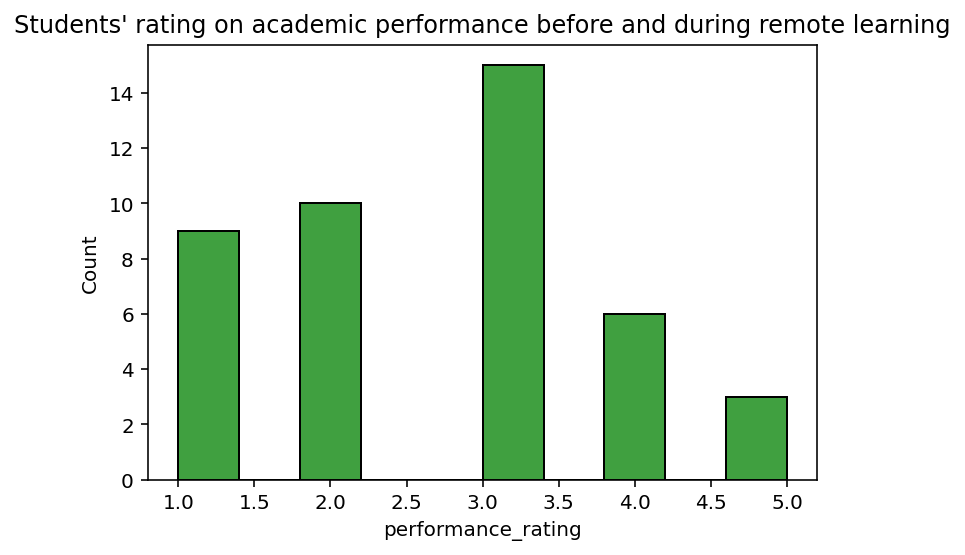

In [37]:
performance_plot = sns.histplot(x='performance_rating', data = rating_df, bins = 10, color = 'green')
performance_plot.set_title("Students' rating on academic performance before and during remote learning")

For how does remote learning affect students academic performance, less than 50% percent students answered their academic performance are positively affected by remote learning.

Text(0.5, 1.0, "Students' rating on experience before and during remote learning")

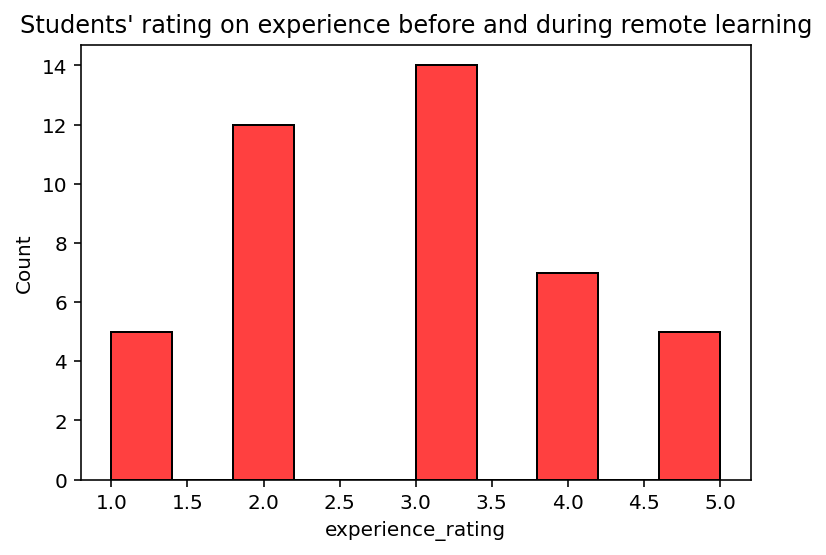

In [38]:
experience_plot = sns.histplot(x='experience_rating', data = rating_df, bins = 10, color = 'red')
experience_plot.set_title("Students' rating on experience before and during remote learning")

In this plot, majority of the students reported neutral on how have their overall experience changed before and by the remote learning during the pandemic. There were also some students feel their performance negatively affected.

#### To summarize, in students self-reported data, we found that most students feel they have increased their study hours during the pandemic but only about 50% of the students feel that their academic performance are negatively affected, and the overall experience of remote learning dissatisfied, with the majority of them picked 'neutral'.
#### Our hypothesis was that remote learning negatively affected students' learning experiences. From students self-reported ratings on studytime, academic performance and overall experiences, we do not yet have strong evidence to support our hypothesis, but the data shows that at least 50% of the students feel their learning experiences are negatively affected by remote learning experiences.

#### Difference between study hours before and during the remote learning in the pandemic?

To further investigate how online learning during the pandemic affects students' academic performance and expectations, we will look at more detailed data - study hours and GPA.

Text(0.5, 1.0, "Students' study hours before and during remote learning")

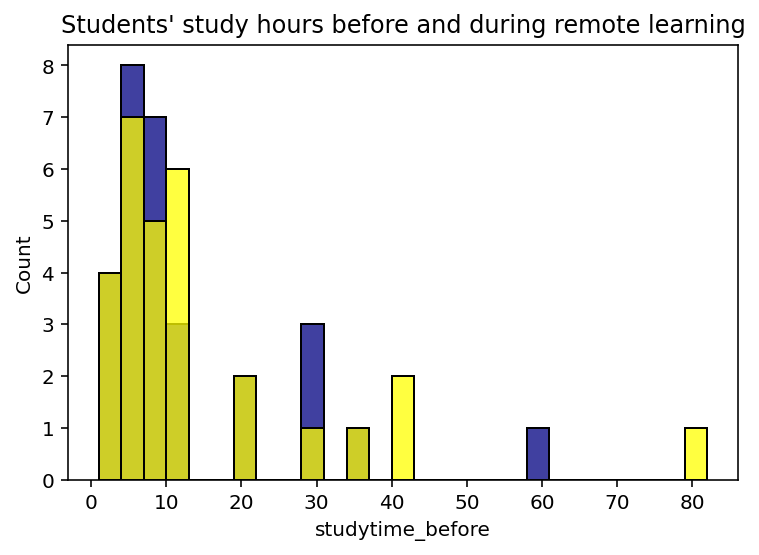

In [39]:
studyhour_before_plot = sns.histplot(x='studytime_before', data = studytime_df, binwidth = 3, color = 'navy')
studyhour_during_plot = sns.histplot(x='studytime_during', data = studytime_df, binwidth = 3, color = 'yellow')
studyhour_during_plot.set_title("Students' study hours before and during remote learning")

From the above plot, we found that there are values that are greater than 30, which is a unrealistic number for study hour of each class per week. Our guess is that the student might misread the question and thought it was asking for total hours per week. We will remove these observation for the clearity of the plot and analysis.

###### Outliers value of study hours before the pandemic

In [75]:
IQR_before = (np.percentile(studytime_df['studytime_before'],75)) - (np.percentile(studytime_df['studytime_before'],25))
IQR_before

4.0

We do not consider the lower bound for the study hour outlier because all data inputs are positive numbers

In [78]:
outlier_val_before = np.percentile(studytime_df['studytime_before'],75) + 1.5*IQR_before
outlier_val_before

14.0

###### Outliers value of study hours during the pandemic

In [77]:
IQR_during = (np.percentile(studytime_df['studytime_during'],75)) - (np.percentile(studytime_df['studytime_during'],25))
IQR_during

6.0

In [79]:
outlier_val_during = np.percentile(studytime_df['studytime_before'],75) + 1.5*IQR_during
outlier_val_during

17.0

### Average study hour before pandemic

In [68]:
add = 0
for h in studytime_df['studytime_before']:
    add += h
avg_hr = (add/studytime_df.shape[0])
avg_hr

6.695652173913044

### Average study hour during pandemic

In [70]:
add_1 = 0
for h in studytime_df['studytime_during']:
    add_1 += h
avg_hr_cov = (add_1/studytime_df.shape[0])
avg_hr_cov

7.021739130434782

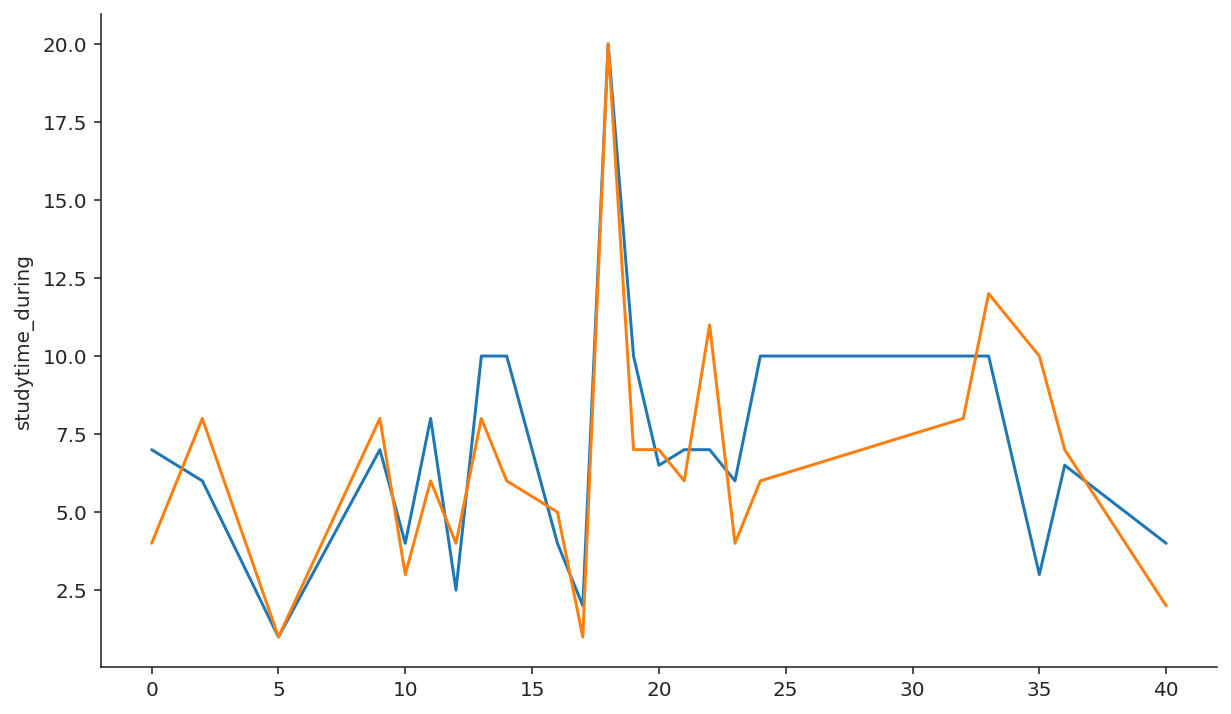

In [89]:
sns.set_style('ticks')
plt.figure(figsize=(10,6))
sns.lineplot(data = studytime_df['studytime_during'])
sns.lineplot(data = studytime_df['studytime_before'])
sns.despine()

In [60]:
studytime_df = studytime_df[(studytime_df['studytime_before'] < 30) & (studytime_df['studytime_during'] < 30)]
studytime_df.reset_index().head()

,index,studytime_before,studytime_during,diff
0,0,4.0,7.0,3.0
1,2,8.0,6.0,-2.0
2,5,1.0,1.0,0.0
3,9,8.0,7.0,-1.0
4,10,3.0,4.0,1.0


Before making the plot, we want to have a look of the average study hours before and during the remote learning to see if there is a difference in mean.



In [41]:
studyhour_before_mean = studytime_df['studytime_before'].mean()
studyhour_during_mean = studytime_df['studytime_during'].mean()
print(studyhour_before_mean, studyhour_during_mean)

6.695652173913044 7.021739130434782


From the calculation, it seems that there is a difference between study hours before and during the pandemic. We will now plot these data to see the distributions.

Text(0.5, 0, 'study hours')

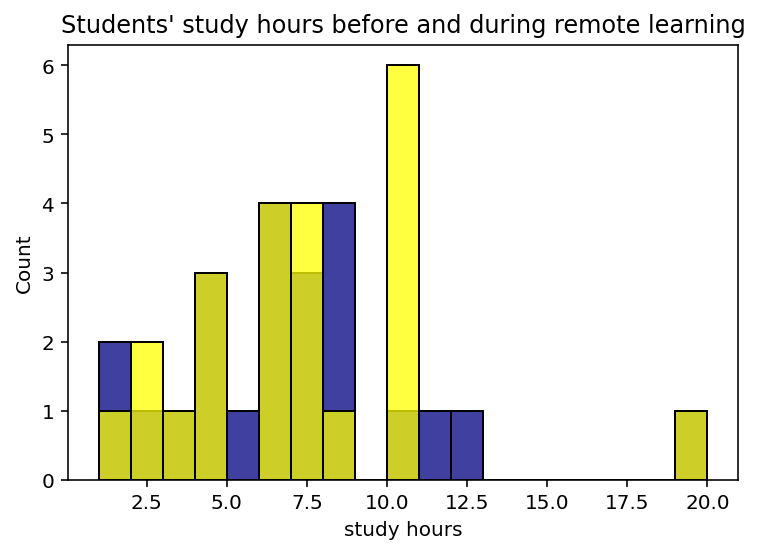

In [42]:
studyhour_before_plot = sns.histplot(x='studytime_before', data = studytime_df, binwidth = 1, color = 'navy')
studyhour_during_plot = sns.histplot(x='studytime_during', data = studytime_df, binwidth = 1, color = 'yellow')
studyhour_during_plot.set_title("Students' study hours before and during remote learning")
studyhour_during_plot.set_xlabel('study hours')

The plot shows that during the pandemic(yellow), the students who study for 10 hours are more than that before the pandemic. But there are some students who studied for over 10 hours per day before the pandemic. Also, there is a single student whose study hour increased to 20 hours during the pandemic.

The plot allows us to compare the overall distribution of study hours before and during the remote learning, but it is not great for visualizing differences, so we will plot a histogram for difference only.

In [43]:
studytime_df = studytime_df.assign(diff = studytime_df['studytime_during'] - studytime_df['studytime_before'])

Text(0.5, 1.0, 'Difference in study time before and during remote learning')

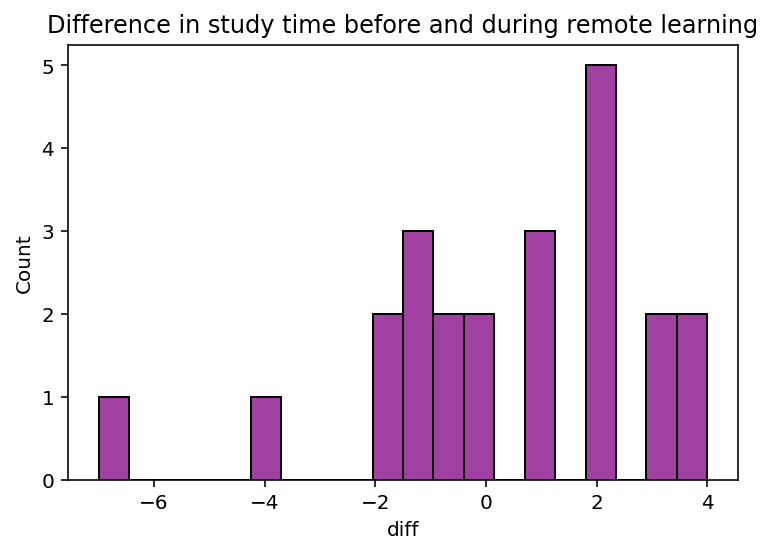

In [44]:
studyhour_diff_plot = sns.histplot(x='diff', data = studytime_df, bins = 20, color = 'purple')
studyhour_diff_plot.set_title("Difference in study time before and during remote learning")

The plot shows that about half of the students' study hours increased during the remote learning, but there are still students whose study hours reduced 6 hours during the remote learning. From this plot, we could not make any conclusion on whether students' study hours increased or not in the pandemic.


#### Difference in academic performance before and during the remote learning?

To measure the academic performance, we will mainly be using students GPA before and during the pandemic.

First, we will take a look of the average GPA before and during remote learning.

In [45]:
gpa_before_mean = GPA_df['gpa_before'].mean()
gpa_during_mean = GPA_df['gpa_during'].mean()
print(gpa_before_mean, gpa_during_mean)

3.619318181818181 3.6950000000000003


Text(0.5, 0, 'GPA')

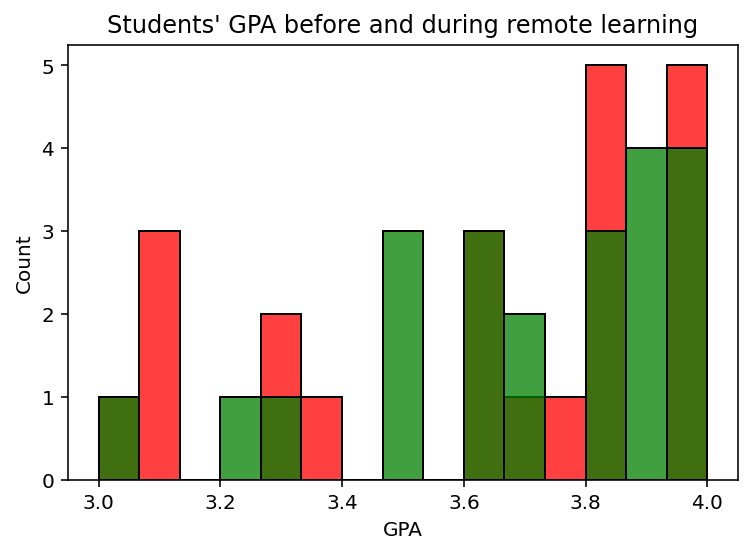

In [46]:
gpa_before_plot = sns.histplot(x='gpa_before', data = GPA_df, bins = 15, color = 'red')
gpa_during_plot = sns.histplot(x='gpa_during', data = GPA_df, bins = 15, color = 'green')
gpa_during_plot.set_title("Students' GPA before and during remote learning")
gpa_during_plot.set_xlabel('GPA')

The plot shows that more students have a close to 3.0 GPA before than during the remote learning.

In [47]:
GPA_df = GPA_df.assign(diff = GPA_df['gpa_during'] - GPA_df['gpa_before'])

Text(0.5, 1.0, 'Difference in GPA before and during remote learning')

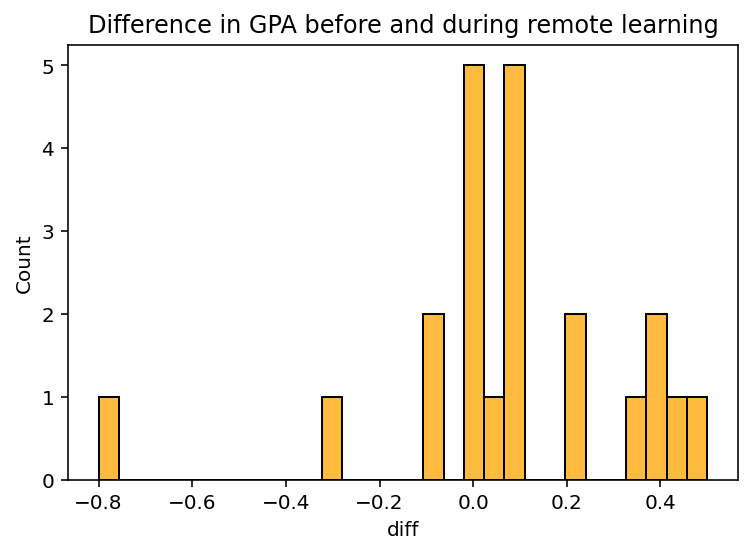

In [48]:
gpa_diff_plot = sns.histplot(x='diff', data = GPA_df, bins = 30, color = 'orange')
gpa_diff_plot.set_title("Difference in GPA before and during remote learning")

From this plot, we can see that most students' GPA actually increased during the remote learning than before.

#### By looking at the difference in studytime and GPA before and during the pandemic, we found that the learning experiences in terms of study hours have increased during the remote learning, however, students average GPA also increased during the remote learning.